In [1]:
!nvidia-smi

Thu Apr  4 10:02:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:21:00.0 Off |                  Off |
| 76%   87C    P2             189W / 200W |  19255MiB / 49140MiB |     83%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import os
import pandas as pd

plt.style.use('seaborn-v0_8')


#フォント設定
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 50 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 15 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 15 # 軸だけ変更されます


#軸設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛りの向き
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛りの向き
#plt.rcParams['axes.grid'] = True # グリッドの作成
#plt.rcParams['grid.linestyle']='--' #グリッドの線種
#plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
#plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
#plt.rcParams['xtick.top'] = True  #x軸の上部目盛り
#plt.rcParams['ytick.right'] = True  #y軸の右部目盛り


#軸大きさ
plt.rcParams["xtick.major.width"] = 1.0             #x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0             #y軸主目盛り線の線幅
plt.rcParams["xtick.minor.width"] = 1.0             #x軸補助目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 1.0             #y軸補助目盛り線の線幅
plt.rcParams["xtick.major.size"] = 10               #x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10               #y軸主目盛り線の長さ#
plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
plt.rcParams["axes.linewidth"] = 1.0                #囲みの太さ


#凡例設定
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.markerscale"] = 20 #markerサイズの倍率


from model import OnlyMLP

In [3]:
class Exp(object):
    def __init__(self) -> None:
        # Learning Parameter
        self.lr=1e-3 
        self.weight_decay =  0.0
        self.p=67 
        self.d_emb = 500
        self.d_model =  48
        self.is_symmetric_input = True

        # Stop training when test loss is <stopping_thresh
        self.stopping_thresh = -1
        self.seed = 1


        self.num_layers = 0
        self.batch_style = 'full' # ['full', 'random'] 
        self.d_vocab = self.p
        self.n_ctx = 2
        self.d_mlp = 1*self.d_model
        self.num_heads = 1
        assert self.d_model % self.num_heads == 0
        self.d_head = self.d_model//self.num_heads  
        self.act_type = 'ReLU'  # ['ReLU', 'GELU']
        self.weight_scale = 1 #0.5576312536233431
        self.prune_rate = 0.4                               
        self.weight_ratio = -1#0.6493382079831002 #0.4152939027995708

        self.use_ln = False

        self.random_answers = np.random.randint(low=0, high=self.p, size=(self.p, self.p))

        self.fns_dict = {'add': lambda x,y:(x+y)%self.p, 'subtract': lambda x,y:(x-y)%self.p, \
                         'x2xyy2':lambda x,y:(x**2+x*y+y**2)%self.p, 'rand':lambda x,y:self.random_answers[x][y],\
                          "only_add": lambda x,y:(x+y)}
        
        
        # pruning
        self.pruner = "mag" # ["rand", "mag", "snip", "grasp", "synflow"]
        self.sparsity = 0.4 #0.7 #0.29#0.4#0.598#1#0.3
        self.schedule = "linear" # ["linear", "exponential"]
        self.scope = "global" # ["global", "local"]
        self.epochs =  1           
        self.reinitialize =  True
        self.train_mode = False
        self.shuffle = False
        self.invert = False
        if self.is_symmetric_input:
            self.batch_size =  (self.p**2 - self.p)//2
        else:
            self.batch_size =  self.p**2

In [4]:
def jaccard_distance(x, y):
    inter = torch.where(x+y==2, 1, 0).sum()
    union = torch.where(x+y==0, 0, 1).sum()
    return 1 - inter/union

/tmp/ipykernel_1033712/2147458073.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
/tmp/ipykernel_1033712/2147458073.py:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')


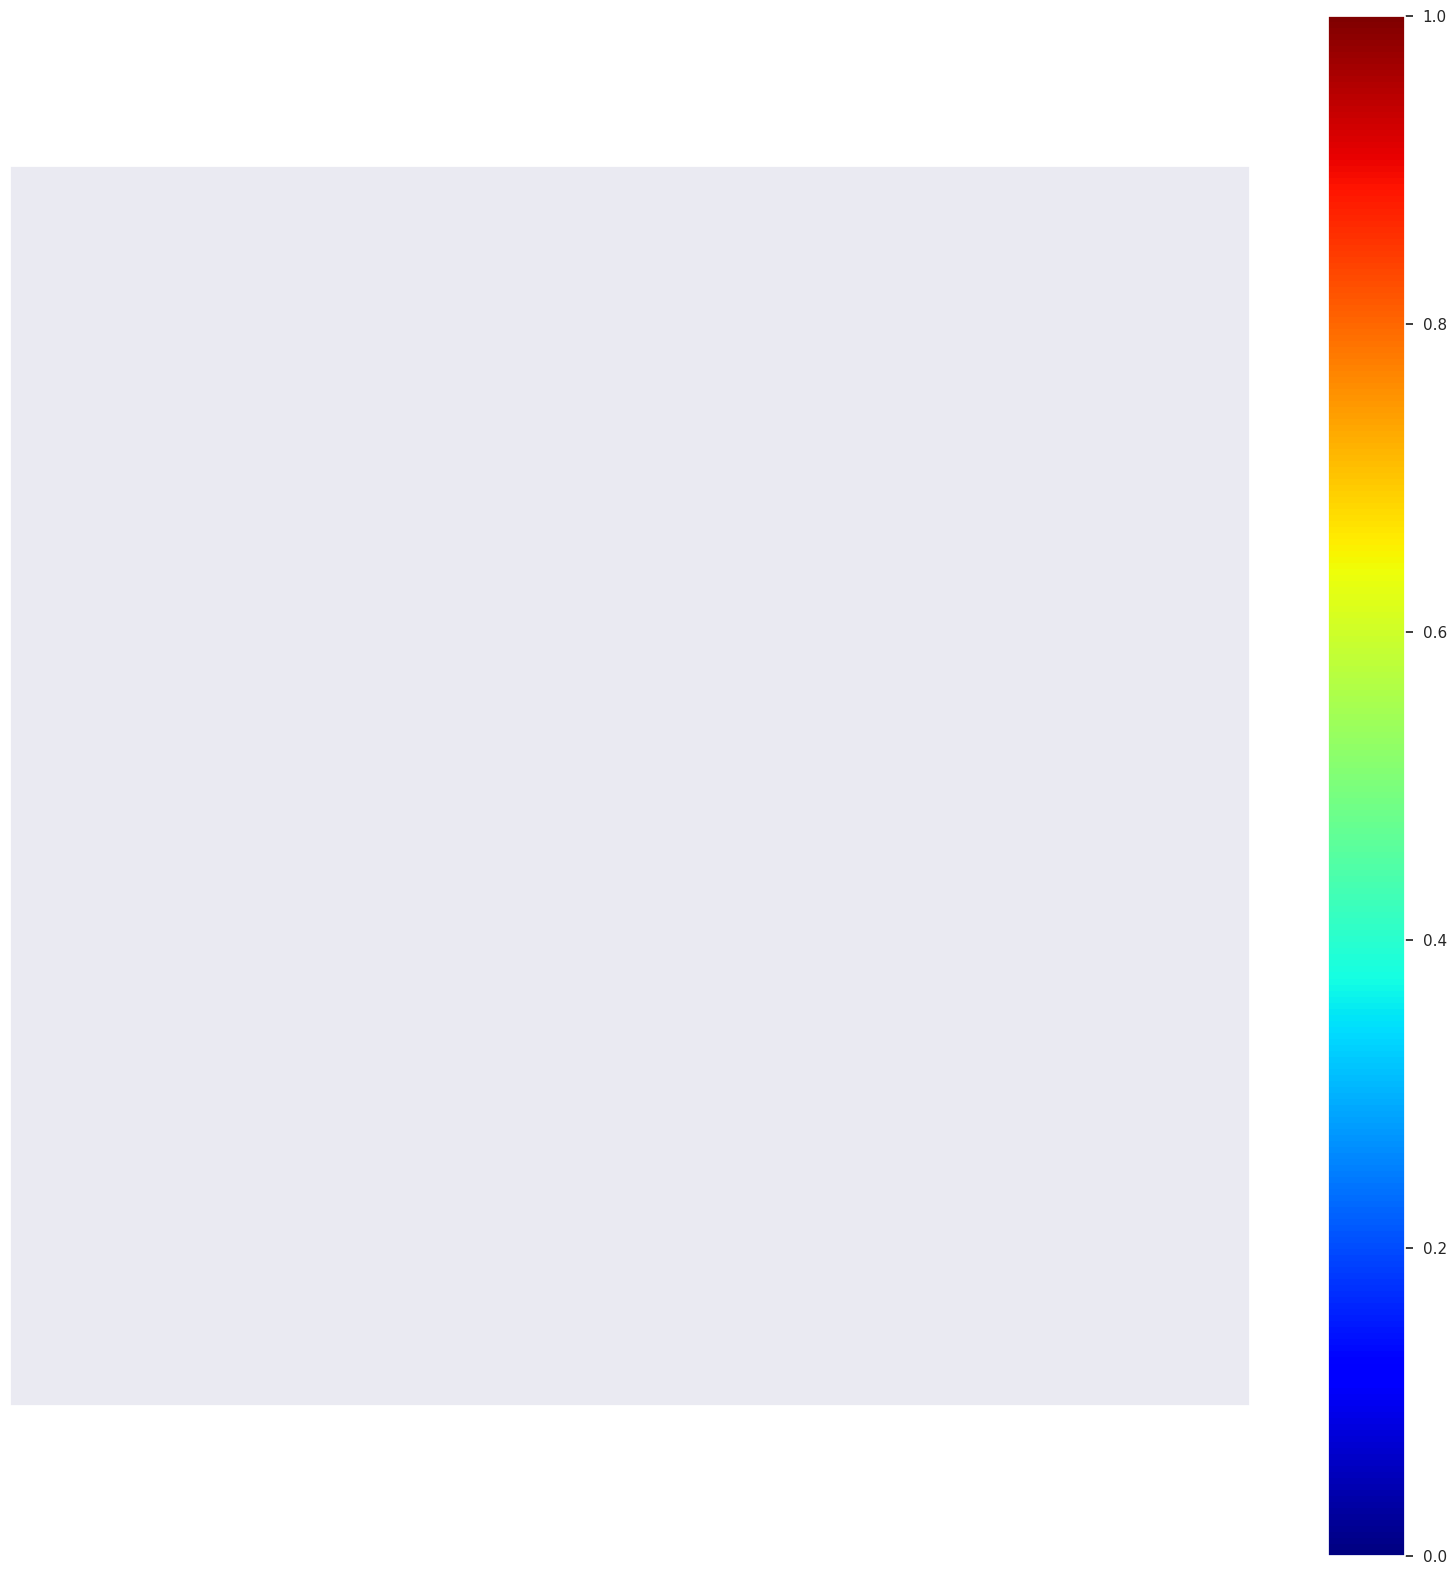

In [6]:
weight_paths = glob(os.path.join("/home/0927/exp3/mlp","*"))
total_masks = {}
for weight_path in weight_paths:
    weight_path = os.path.join(weight_path,"0.pth")
    name = weight_path.split("/")[-2].split("_")[-1]
    config = Exp()
    model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model.load_state_dict(torch.load(weight_path)["model"])
    W_E_mask = model.state_dict()["embed.weight_mask"]
    W_inproj_mask = model.state_dict()["inproj.weight_mask"]
    W_outproj_mask = model.state_dict()["outproj.weight_mask"]
    W_U_mask = model.state_dict()["unembed.weight_mask"]
    total_mask = torch.cat([W_E_mask.view(-1), W_inproj_mask.view(-1), W_outproj_mask.view(-1), W_U_mask.view(-1)], dim=0)
    # print(total_mask.shape)
    total_masks[name] = total_mask
jaccard_dis = torch.zeros((len(total_masks), len(total_masks)))
for i, (name1, mask1) in enumerate(total_masks.items()):
    for j, (name2, mask2) in enumerate(total_masks.items()):
        jaccard_dis[i][j] = jaccard_distance(mask1, mask2)

plt.figure(figsize=(20,20))
plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
#plt.title("Jaccard Distance", fontsize=４0)
plt.savefig("jacard_distance.png")
plt.show()

os.makedirs("/home/mask_sim", exist_ok=True)
np.save("/home/mask_sim/jacard_distance.npy", jaccard_dis.numpy())


In [7]:
jaccard_dis = np.insert(jaccard_dis.numpy(), 0, jaccard_dis.numpy()[0], axis=0)

IndexError: index 0 is out of bounds for axis 0 with size 0

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

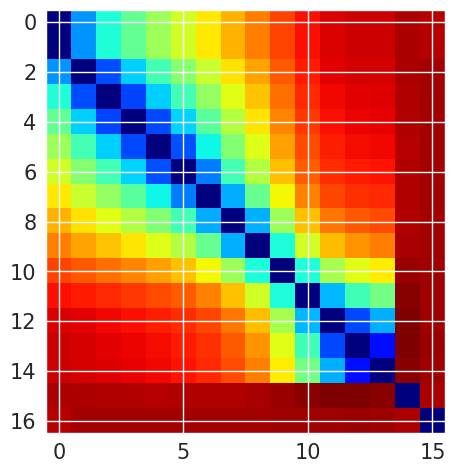

In [ ]:
plt.imshow(jaccard_dis, cmap=cm.jet, interpolation='nearest')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

[0.73728704 0.7486398  0.74892914 0.7497112  0.7491162  0.750034
 0.7489631  0.75040746 0.75103515 0.752813   0.75350577 0.753472
 0.75453514 0.75355643 0.7436843  0.        ]


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

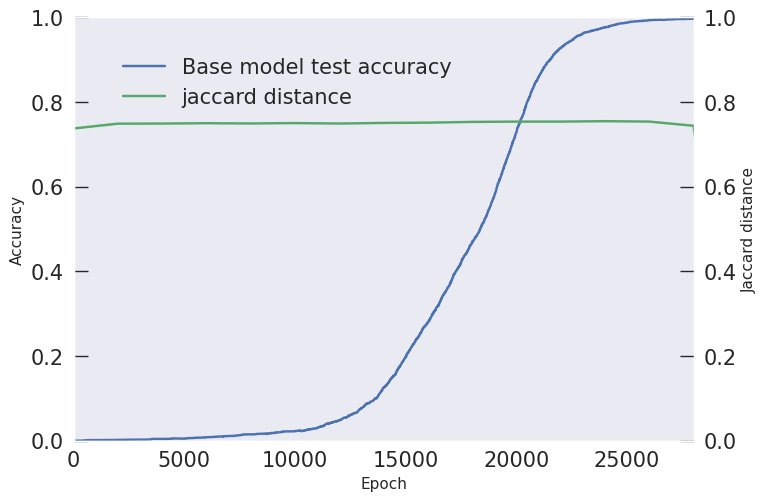

In [ ]:
path  = "/home/exp0_mlp_test.csv"

df1 = pd.read_csv(path)
print(jaccard_dis.numpy()[-1])
epochs = np.arange(0, (len(jaccard_dis.numpy()[-1]))*2000, 2000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1=ax1.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")


ax2 = ax1.twinx()
ln2=ax2.plot(epochs,jaccard_dis.numpy()[-1],"C1",label="jaccard distance" )

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.05, 0.95),fontsize=15)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Jaccard distance')
ax1.set_ylim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax1.set_xlim([0, 28000])
ax2.set_xlim([0, 28000])
ax1.grid(False)
ax2.grid(False)



#plt.savefig("fig/exp0_mlp.png", dpi=300, bbox_inches='tight')


# weight similarity

In [ ]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
def weight_similarity(x, y):
    total_similarity = 0
    for w1,w2 in zip(x.values(),y.values()):
        total_similarity += cos(w1.view(-1), w2.view(-1))
    return total_similarity/len(x)
        

/tmp/ipykernel_1033712/4072766111.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
/tmp/ipykernel_1033712/4072766111.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')


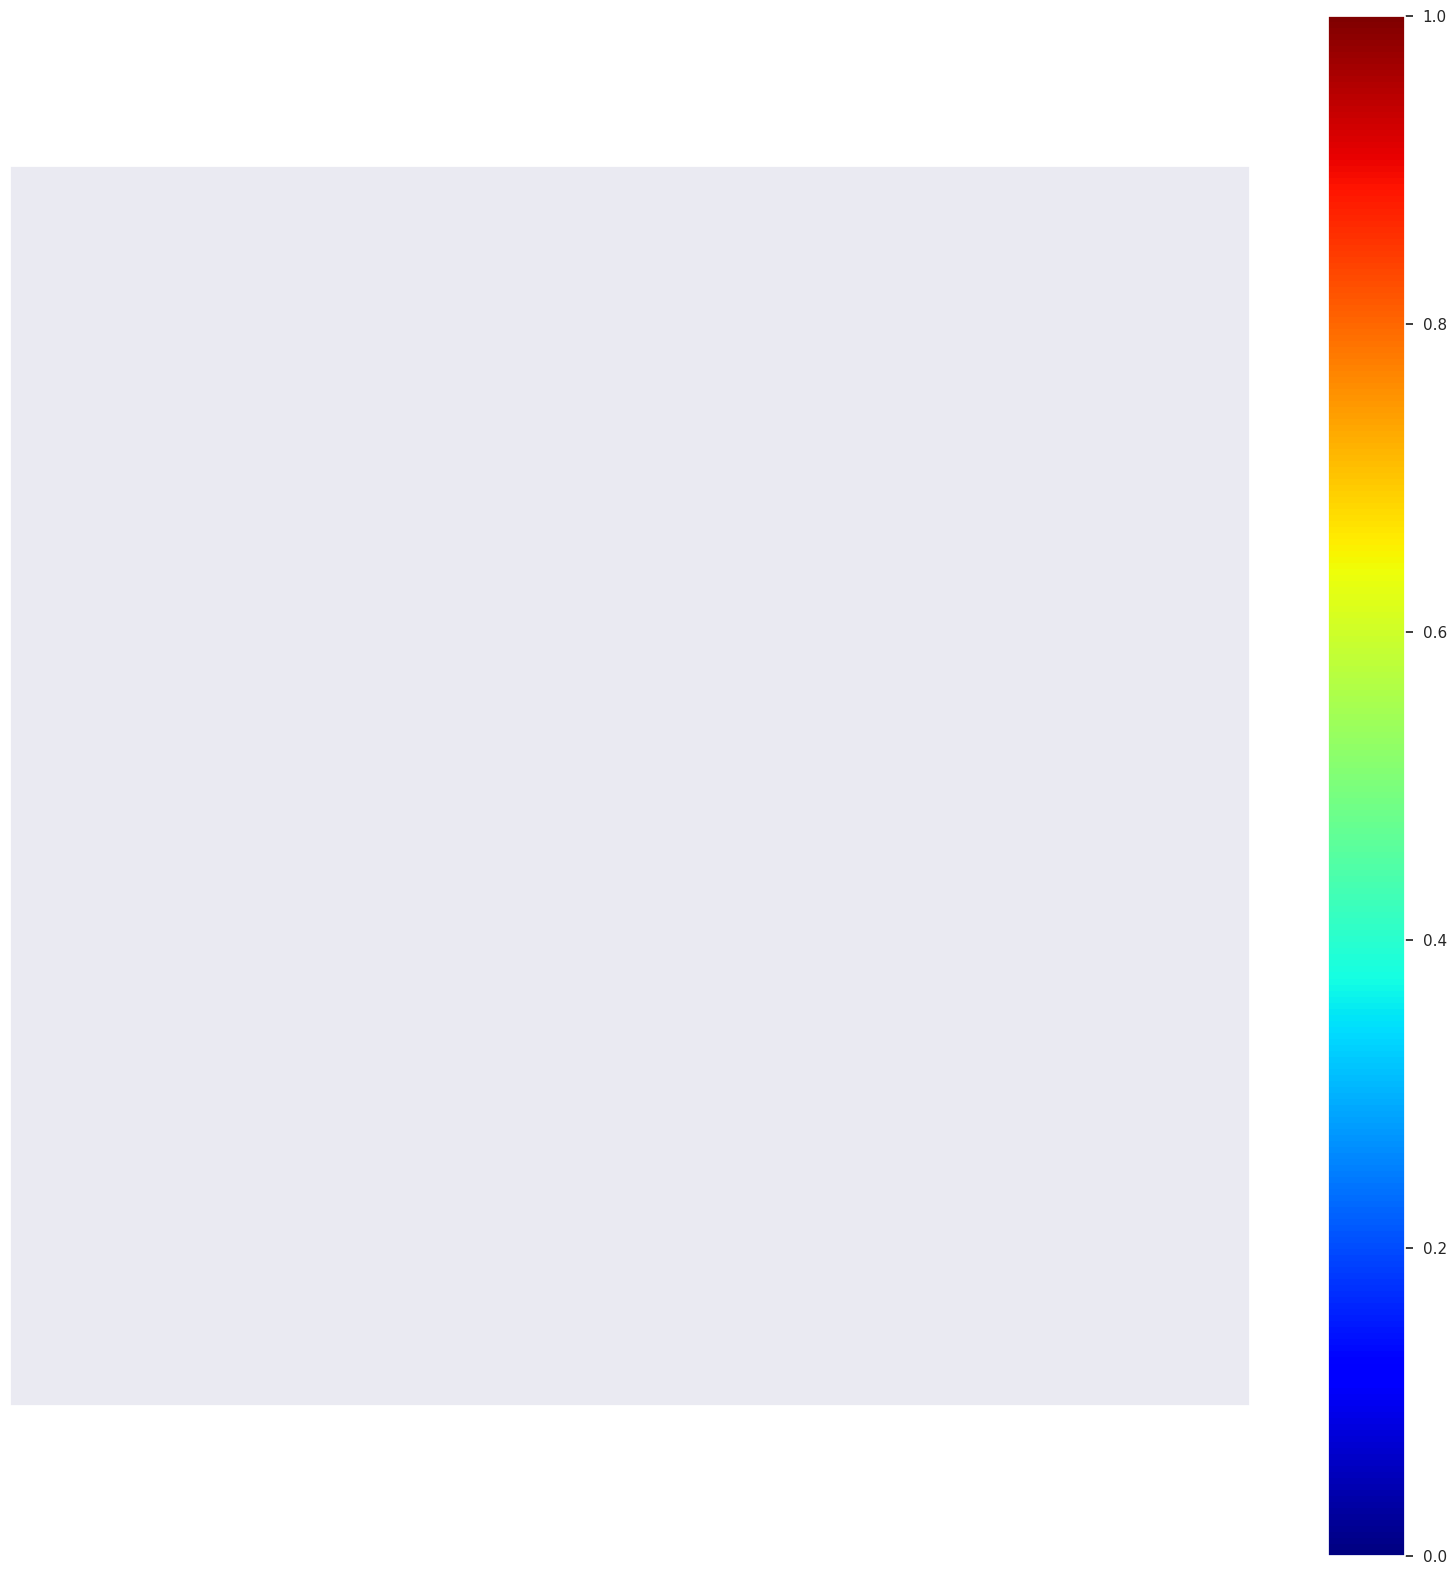

In [8]:
weight_paths = glob(os.path.join("/home/0927/exp3/mlp","*"))
total_weights = {}
for weight_path in weight_paths:
    weight_path = os.path.join(weight_path,"0.pth")
    name = weight_path.split("/")[-2].split("_")[-1]
    if "final" in name :
        continue
    config = Exp()
    model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model.load_state_dict(torch.load(weight_path)["model"])
    total_weights[name] = model.state_dict()

weight_sim = torch.zeros((len(total_weights), len(total_weights)))
for i, (name1, weight1) in enumerate(total_weights.items()):
    for j, (name2, weight2) in enumerate(total_weights.items()):
        weight_sim[i][j] = weight_similarity(weight1, weight2)

plt.figure(figsize=(20,20))
plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
#plt.title("Jaccard Distance", fontsize=４0)
plt.savefig("weight_sim.png")
plt.show()


In [9]:
path  = "/home/exp0_mlp_test.csv"

df1 = pd.read_csv(path)
print(jaccard_dis.numpy()[-1])
epochs = np.arange(2000, (len(jaccard_dis.numpy()[-1])+1)*2000, 2000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1=ax1.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")


ax2 = ax1.twinx()
ln2=ax2.plot(epochs,jaccard_dis.numpy()[-1],"C1",label="jaccard distance" )
ln2=ax2.plot(epochs,weight_sim.numpy()[-1],"C1",label="jaccard distance" )

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.05, 0.95),fontsize=15)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Jaccard distance')
ax1.set_ylim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax1.grid(False)
ax2.grid(False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/exp0_mlp_test.csv'

{'2k': tensor([1., 0., 1.,  ..., 0., 0., 1.]), '4k': tensor([1., 0., 1.,  ..., 0., 0., 1.]), '6k': tensor([1., 0., 0.,  ..., 0., 0., 1.]), '8k': tensor([1., 0., 0.,  ..., 0., 0., 0.]), '1k0': tensor([1., 0., 0.,  ..., 0., 0., 0.]), '12k': tensor([1., 0., 0.,  ..., 1., 0., 0.]), '14k': tensor([0., 0., 0.,  ..., 1., 0., 0.]), '16k': tensor([0., 0., 0.,  ..., 1., 0., 0.]), '18k': tensor([0., 0., 0.,  ..., 1., 0., 0.]), '2k0': tensor([0., 0., 0.,  ..., 1., 0., 0.]), '22k': tensor([0., 0., 0.,  ..., 1., 0., 0.]), '24k': tensor([0., 1., 0.,  ..., 1., 0., 0.]), '26k': tensor([1., 1., 0.,  ..., 1., 0., 0.]), '28k': tensor([1., 1., 0.,  ..., 1., 0., 0.]), 'pruner': tensor([1., 0., 0.,  ..., 1., 0., 0.])}
{'2k': tensor([0., 1., 0.,  ..., 0., 0., 1.]), '4k': tensor([0., 1., 0.,  ..., 0., 0., 1.]), '6k': tensor([1., 1., 0.,  ..., 0., 0., 1.]), '8k': tensor([1., 1., 0.,  ..., 0., 0., 1.]), '1k0': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '12k': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '14k': tensor([0

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


{'2k': tensor([0., 0., 0.,  ..., 0., 0., 0.]), '4k': tensor([0., 0., 1.,  ..., 0., 0., 1.]), '6k': tensor([0., 0., 1.,  ..., 0., 0., 0.]), '8k': tensor([0., 0., 1.,  ..., 0., 0., 0.]), '1k0': tensor([0., 0., 1.,  ..., 0., 0., 0.]), '12k': tensor([0., 0., 1.,  ..., 0., 0., 0.]), '14k': tensor([0., 0., 0.,  ..., 0., 0., 0.]), '16k': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '18k': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '2k0': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '22k': tensor([0., 1., 0.,  ..., 0., 0., 0.]), '24k': tensor([1., 1., 0.,  ..., 0., 0., 0.]), '26k': tensor([1., 1., 0.,  ..., 0., 1., 0.]), '28k': tensor([1., 1., 0.,  ..., 0., 1., 0.]), 'pruner': tensor([0., 0., 0.,  ..., 1., 0., 0.])}


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

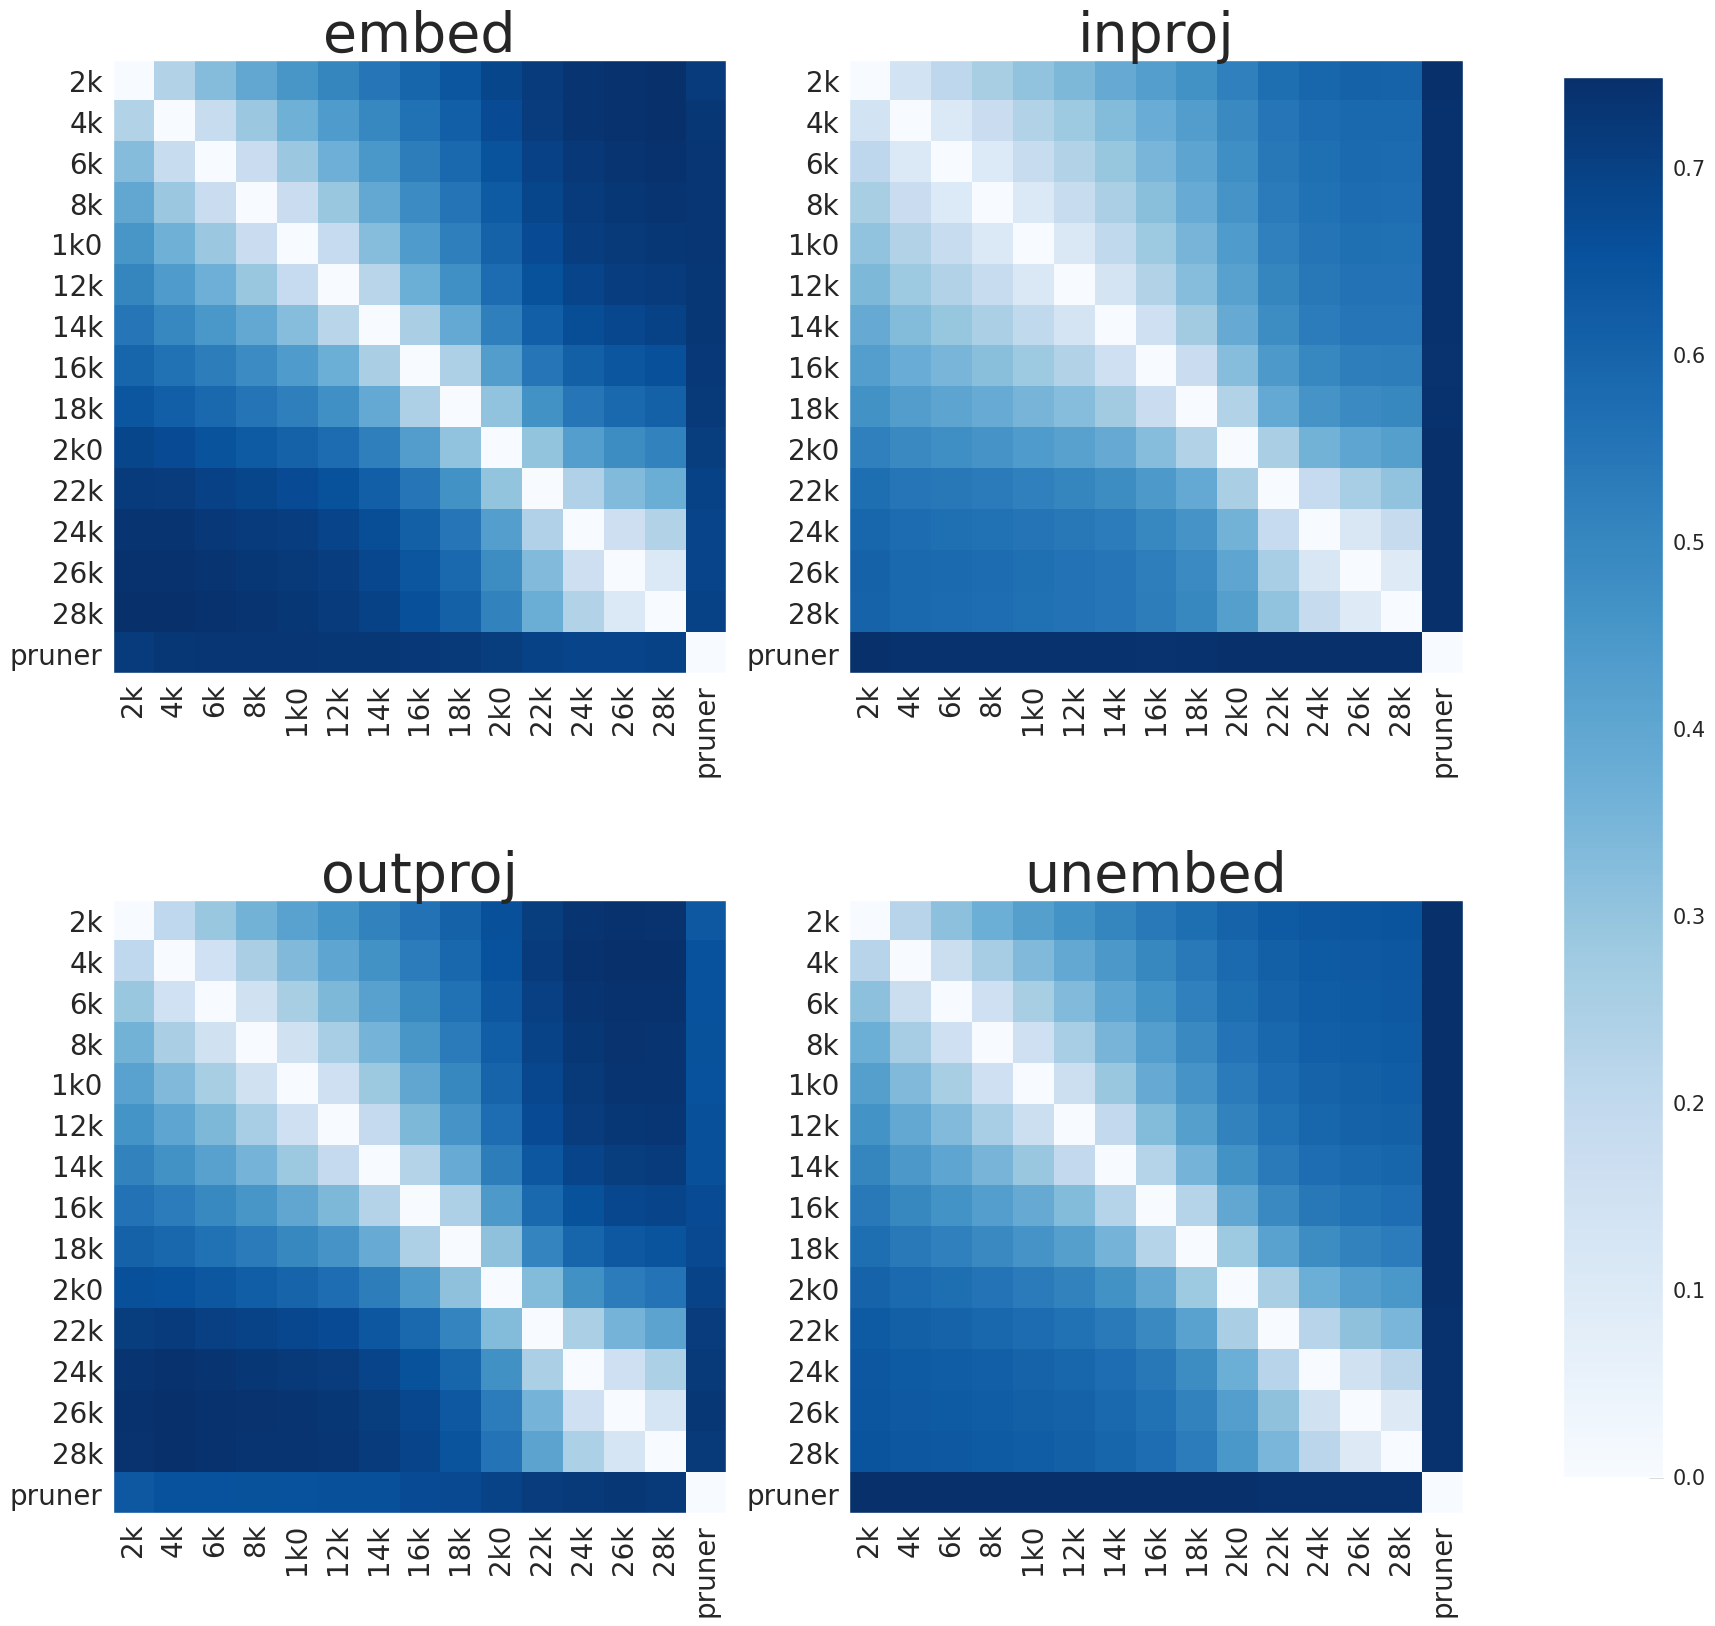

In [ ]:
weight_paths = glob(os.path.join("/home/0927/exp3/mlp","*"))
fig, ax = plt.subplots(2,2, figsize=(20,20))
jaccard_distance_layer = {}
for layer_i, layer in enumerate(["embed", "inproj", "outproj", "unembed"]):
    total_masks = {}    
    for weight_path in weight_paths:
        weight_path = os.path.join(weight_path,"0.pth")
        name = weight_path.split("/")[-2].split("_")[-1].replace("epoch", "").replace("000", "k")
        if "final" in name :
            continue
        config = Exp()
        model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                d_model=config.d_model, d_emb=config.d_emb, \
                                act_type=config.act_type,  use_ln=config.use_ln, \
                                weight_scale=config.weight_scale)
        model.load_state_dict(torch.load(weight_path)["model"])
        W_mask = model.state_dict()[f"{layer}.weight_mask"]
        total_masks[name] = W_mask.view(-1)
    print(total_masks)
    jaccard_dis = torch.zeros((len(total_masks), len(total_masks)))
    for i, (name1, mask1) in enumerate(total_masks.items()):
        for j, (name2, mask2) in enumerate(total_masks.items()):
            jaccard_dis[i][j] = jaccard_distance(mask1, mask2)
    jaccard_distance_layer[layer] = jaccard_dis.numpy()
    ax[layer_i//2][layer_i%2].imshow(jaccard_dis.numpy(), cmap=cm.Blues, interpolation='nearest')
    ax[layer_i//2][layer_i%2].grid(False)
    ax[layer_i//2][layer_i%2].set_xticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_yticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_xticklabels(total_masks.keys(), rotation=90, fontsize=20)
    ax[layer_i//2][layer_i%2].set_yticklabels(total_masks.keys(), fontsize=20)
    ax[layer_i//2][layer_i%2].set_title(f"{layer}", fontsize=40)
    #plt.title("Jaccard Distance", fontsize=４0)
# colorbar
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[0][0].imshow(jaccard_distance_layer["embed"], cmap=cm.Blues, interpolation='nearest'), cax=cbar_ax)
torch.save(jaccard_distance_layer, "/home/mask_sim/jaccard_distance_layer.pth")
plt.savefig("jacard_distance.png")
plt.show()




# plt.figure(figsize=(20,20))
# plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
# plt.grid(False)
# plt.colorbar()
# plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
# plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
# #plt.title("Jaccard Distance", fontsize=４0)
# plt.savefig("jacard_distance.png")
# plt.show()

# os.makedirs("/home/mask_sim", exist_ok=True)
# np.save("/home/mask_sim/jacard_distance.npy", jaccard_dis.numpy())

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

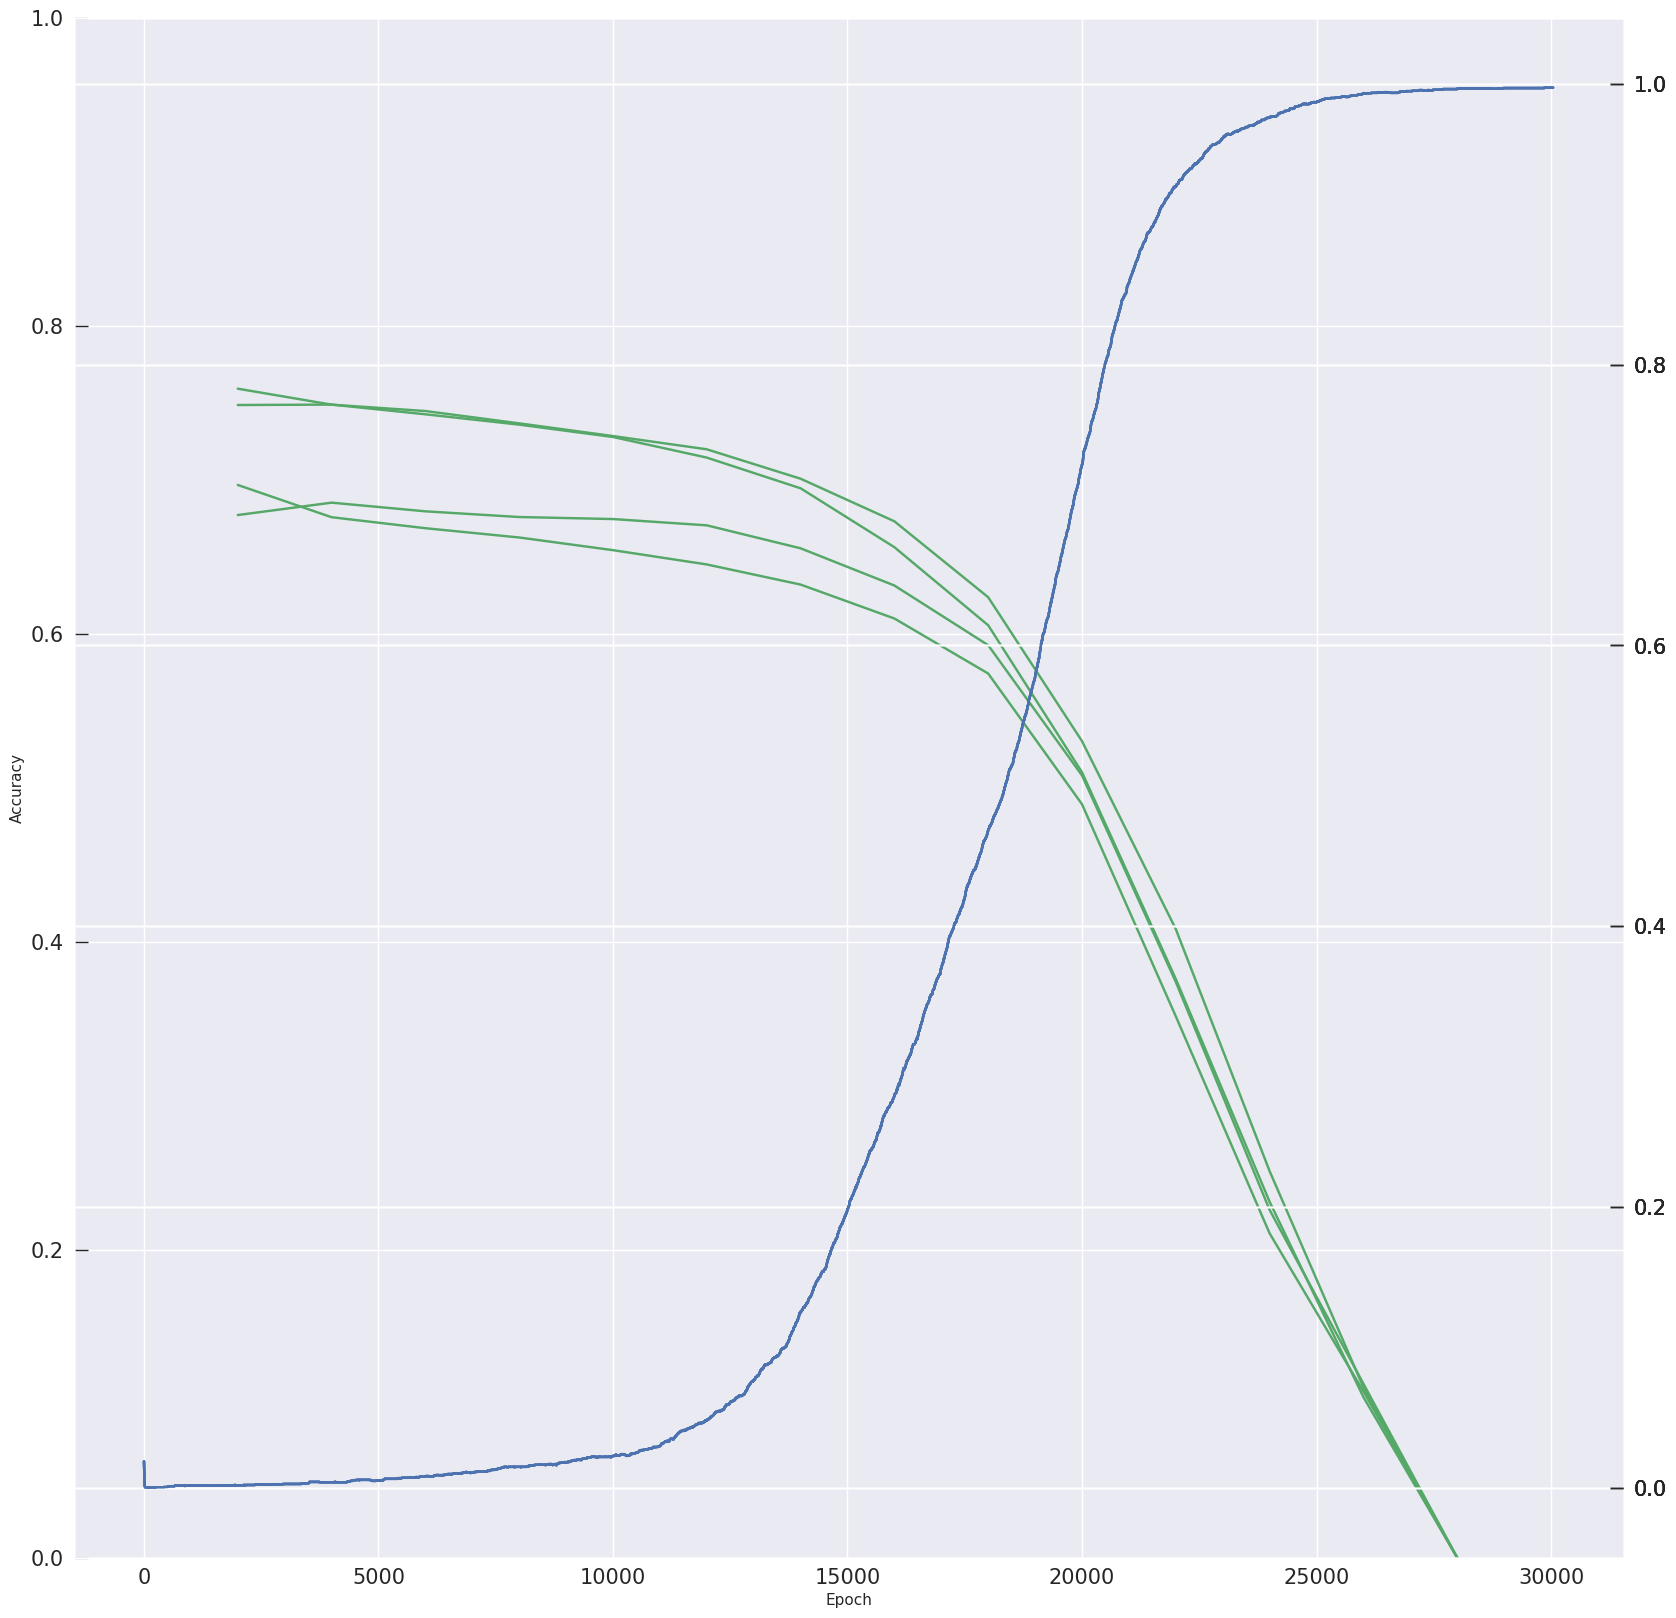

In [ ]:
path  = "/home/exp0_mlp_test.csv"
df1 = pd.read_csv(path)

epochs = np.arange(2000, (len(jaccard_dis.numpy()[-1])+1)*2000, 2000)
fig, ax = plt.subplots(1,1, figsize=(20,20))
for i, (layer, jacard_dis) in enumerate(jaccard_distance_layer.items()):
    ax.plot(epochs,jacard_dis[-1],"C1",label="jaccard distance" )
    ax2 = ax.twinx()
    ax2.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([0.0, 1.0])
    #plt.title("Jaccard Distance", fontsize=４0)


In [34]:
torch.save(jaccard_distance_layer, "/home/mask_sim/jaccard_distance_layer.pth")

## memo

embed
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
{'5': tensor([1., 0., 1.,  ..., 1., 1., 1.]), '10': tensor([1., 0., 1.,  ..., 0., 1., 1.]), '15': tensor([1., 0., 1.,  ..., 0., 1., 1.]), '20': tensor([1., 0., 1.,  ..., 0., 1., 1.]), '25': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '30': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '35': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '40': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '45': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '50': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '55': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '60': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '65': tensor([1., 1., 1.,  ..., 0., 1., 1.]), '70': tensor([1., 1., 1.,  ..., 0., 1., 0.]), '75': tensor([1., 1., 1.,  ..., 0., 1., 0.]), '80': tensor([1., 1., 1.,  ..., 0., 1., 0.]), '85': tensor([1., 1., 1.,  ..., 0., 1., 0.]), '90': tensor([1., 1., 1.,  ..., 0., 1., 0.]), '95': tensor([1., 1., 1., 

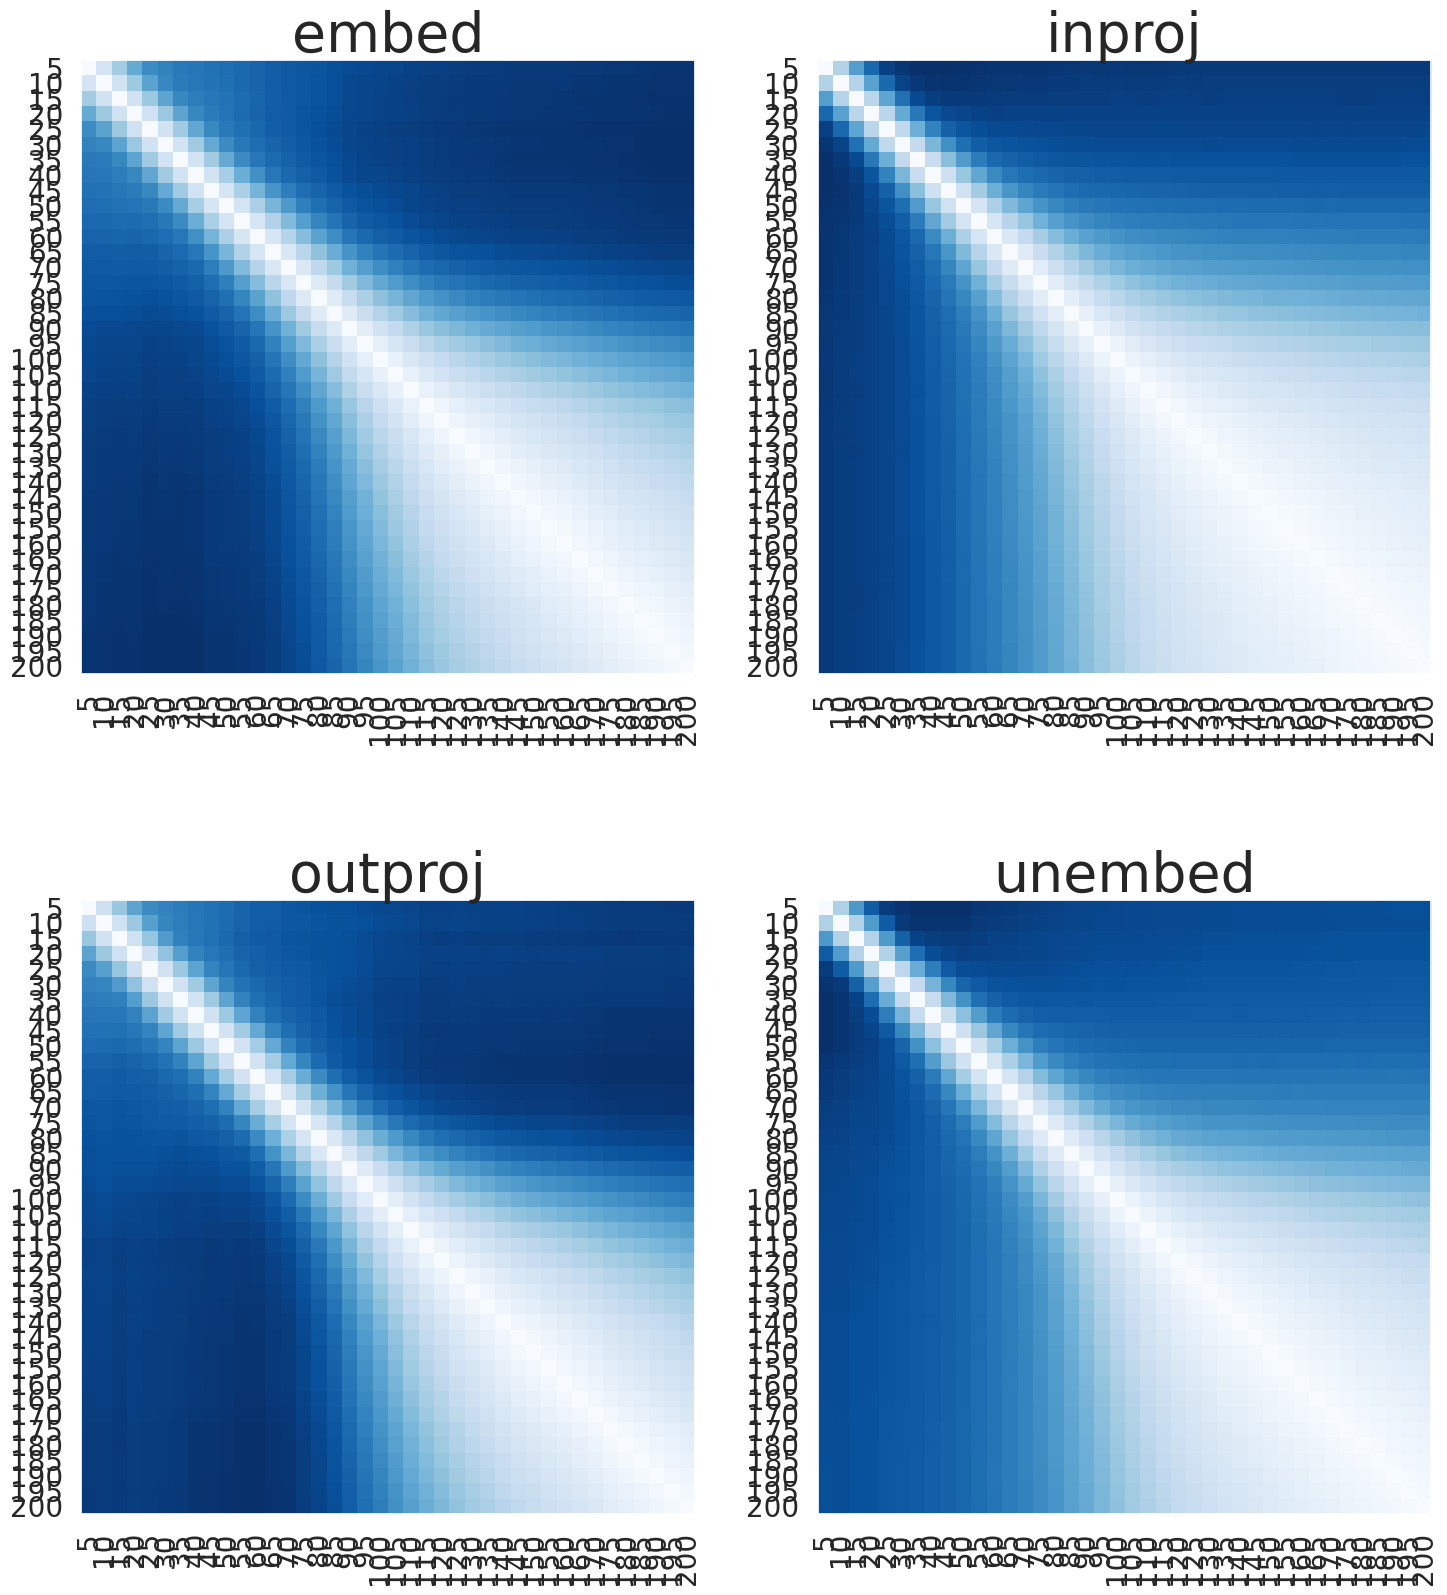

In [14]:
weight_paths = glob(os.path.join("/workspace/Grokking-Tickets/0404/ticket","*"))
fig, ax = plt.subplots(2,2, figsize=(20,20))
jaccard_distance_layer = {}
for layer_i, layer in enumerate(["embed", "inproj", "outproj", "unembed"]):
    total_masks = {}    
    print(layer)
    for weight_path in weight_paths:
        weight_path = os.path.join(weight_path,"final.pth")
        name = weight_path.split("/")[-2].split("_")[-1].replace("epoch", "").replace("000", "k")
        print(name)
        if "final" in name :
            continue
        config = Exp()
        model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                d_model=config.d_model, d_emb=config.d_emb, \
                                act_type=config.act_type,  use_ln=config.use_ln, \
                                weight_scale=config.weight_scale)
        model.load_state_dict(torch.load(weight_path)["model"])
        W_mask = model.state_dict()[f"{layer}.weight_mask"]
        total_masks[name] = W_mask.view(-1)
    print(total_masks)
    jaccard_dis = torch.zeros((len(total_masks), len(total_masks)))
    for i, (name1, mask1) in enumerate(total_masks.items()):
        for j, (name2, mask2) in enumerate(total_masks.items()):
            jaccard_dis[i][j] = jaccard_distance(mask1, mask2)
    jaccard_distance_layer[layer] = jaccard_dis.numpy()
    ax[layer_i//2][layer_i%2].imshow(jaccard_dis.numpy(), cmap=cm.Blues, interpolation='nearest')
    ax[layer_i//2][layer_i%2].grid(False)
    ax[layer_i//2][layer_i%2].set_xticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_yticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_xticklabels(total_masks.keys(), rotation=90, fontsize=20)
    ax[layer_i//2][layer_i%2].set_yticklabels(total_masks.keys(), fontsize=20)
    ax[layer_i//2][layer_i%2].set_title(f"{layer}", fontsize=40)
    #plt.title("Jaccard Distance", fontsize=４0)
# colorbar
plt.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(ax[0][0].imshow(jaccard_distance_layer["embed"], cmap=cm.Blues, interpolation='nearest'), cax=cbar_ax)
torch.save(jaccard_distance_layer, "/workspace/Grokking-Tickets/mask_sim/jaccard_distance_layer_memo.pth")
plt.savefig("jacard_distance.png")
plt.show()




# plt.figure(figsize=(20,20))
# plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
# plt.grid(False)
# plt.colorbar()
# plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
# plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
# #plt.title("Jaccard Distance", fontsize=４0)
# plt.savefig("jacard_distance.png")
# plt.show()

# os.makedirs("/home/mask_sim", exist_ok=True)
# np.save("/home/mask_sim/jacard_distance.npy", jaccard_dis.numpy())